In [4]:
import numpy as np

import librosa
import librosa.display

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F
import torchaudio
from torchaudio.models import WaveRNN

from torchvision.utils import make_grid 
import matplotlib.pyplot as plt    
import os
import random
from tqdm import tqdm 

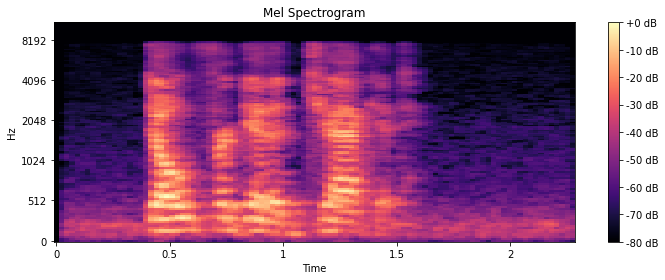

In [5]:
#Visualising the data

crema_d_spec_path = './AudioWAV/1001_DFA_ANG_XX.wav'
y, sr = librosa.load(crema_d_spec_path)

# Compute the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibel scale (log scale)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [6]:
waveform, sample_rate = torchaudio.load(crema_d_spec_path)
print(waveform.size(), sample_rate)

torch.Size([1, 36409]) 16000


In [149]:
#calculation
mw = 0
ms = 0
max_waveform_length = 314818
directory = './ALL'
for filename in os.listdir(directory):
    if filename.endswith('.wav'):
        
        filepath = os.path.join(directory, filename)
        
        
        # Load audio waveform
        waveform, sr = torchaudio.load(filepath)

        waveform_length = waveform.size(1)
        if waveform_length < max_waveform_length:
            padding = torch.zeros(1, max_waveform_length - waveform_length)
            waveform = torch.cat([waveform, padding], dim=1)
        elif waveform_length > max_waveform_length:
            waveform = waveform[:, :max_waveform_length]
        
        # # Compute spectrogram
        mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=64, n_fft=1024, hop_length=160)
        spectrogram = mel_spec_transform(waveform)

        mw = max(mw, waveform.size(1))
        ms = max(ms, spectrogram.size(2))

print(mw)
print(ms)  

314818
1968


In [ ]:
#calculation
mw = 0
ms = 0
max_waveform_length = 314818
directory = './ALL'
for filename in os.listdir(directory):
    if filename.endswith('.wav'):
        
        filepath = os.path.join(directory, filename)
        
        
        # Load audio waveform
        waveform, sr = torchaudio.load(filepath)

        waveform_length = waveform.size(1)
        if waveform_length < max_waveform_length:
            padding = torch.zeros(1, max_waveform_length - waveform_length)
            waveform = torch.cat([waveform, padding], dim=1)
        elif waveform_length > max_waveform_length:
            waveform = waveform[:, :max_waveform_length]
        
        # # Compute spectrogram
        mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=64, n_fft=1024, hop_length=160)
        spectrogram = mel_spec_transform(waveform)

        mw = max(mw, waveform.size(1))
        ms = max(ms, spectrogram.size(2))

print(mw)
print(ms)  

In [78]:

def get_label(type, filename):

    if(type == 'save'):
        if filename[-8:-6]=='_a':
            return 'ANG'
        elif filename[-8:-6]=='_d':
            return 'DIS'
        elif filename[-8:-6]=='_f':
            return 'FEA'
        elif filename[-8:-6]=='_h':
            return 'HAP'
        elif filename[-8:-6]=='_n':
            return 'NEU'
        elif filename[-8:-6]=='sa':
            return 'SAD'
        elif filename[-8:-6]=='su':
            return 'SU'
        else:
            return ''
    
    elif(type == 'crema_d'):
        return filename.split('_')[2]

    elif(type == 'ravdess'):
        part = filename.split('.')[0].split('-')
        emotion = int(part[2])
        if emotion == 1 or emotion == 2:
            return 'NEU'
        elif emotion == 3:
            return 'HAP'
        elif emotion == 4:
            return 'SAD'
        elif emotion == 5:
            return 'ANG'
        elif emotion == 6:
            return 'FEA'
        elif emotion == 7:
            return 'DIS'
        elif emotion == 8:
            return 'SU'

    elif(type == 'tess'):
        i = filename.split('_')[2]

        if i == 'angry':
            return 'ANG'
            
        elif i == 'disgust':
            return 'DIS'
            
        elif i == 'fear':
            return 'FEA'
            
        elif i == 'happy':
            return 'HAP'
            
        elif i == 'neutral':
            return 'NEU'
                                        
        elif i == 'ps':
            return 'SU'

        elif i == 'sad':
            return 'SAD'
            
    return ''

#for ravdess and tess
def load_other(directory, type):

    dir_list = os.listdir(diectory)
    dir_list.sort()
    emotion = []

    for i in dir_list:
        fname = os.listdir(directory + i)
        d = load_dataset(fname, type, 314818, 1968)
    return d

def load_dataset(directory, type, max_waveform_length, max_spec_len):
    dataset = []
    # emotion_to_number = {'NEU': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'DIS': 4, 'FEA': 5, 'SU':6}
    emotion_to_number = {'NEU': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'DIS': 4, 'FEA': 5}
    max_len = 0
    
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            
            filepath = os.path.join(directory, filename)
            emotion = get_label(type,filename)
            emotion_no = emotion_to_number[emotion]
            emotion_label = torch.zeros(6)
            emotion_label[emotion_no] = 1
            
            # Load audio waveform
            waveform, sr = torchaudio.load(filepath)
            
            waveform_length = waveform.size(1)
            if waveform_length < max_waveform_length:
                padding = torch.zeros(1, max_waveform_length - waveform_length)
                waveform = torch.cat([waveform, padding], dim=1)
            elif waveform_length > max_waveform_length:
                waveform = waveform[:, :max_waveform_length]
            
            # Compute spectrogram
            mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=80, n_fft=400, hop_length=160)
            # mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=64, n_fft=1024, hop_length=160)
            spectrogram = mel_spec_transform(waveform)
            
            # Pad or truncate spectrogram to max_spec_len
            spec_len = spectrogram.size(2)
            if spec_len < max_spec_len:
                padding = torch.zeros(1, 80, max_spec_len - spec_len)  # Add a new axis
                spectrogram = torch.cat([spectrogram, padding], dim=2)

            elif spec_len > max_spec_len:
                spectrogram = spectrogram[:, :, :max_spec_len]
            
            
            epsilon = 1e-10
            spec_db = 10 * torch.log10(spectrogram + epsilon)
            
            dataset.append((spec_db, emotion_label))

    return dataset


def split_dataset(dataset, batch_size, train_ratio=0.9):

    # Split dataset into training and testing sets
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader objects for training and testing sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

In [79]:
crema_d_path = './AudioWAV'

data_crema = load_dataset(crema_d_path, 'crema_d', 80080, 500)

dataset = data_crema

print(len(dataset))


7442


In [81]:
train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, 32)

In [82]:
print(len(dataset))
for batch_idx, (s, l) in enumerate(train_dataloader):
    print(s.size())
    print(l.size())
    break


7442
torch.Size([32, 1, 80, 500])
torch.Size([32, 6])


In [87]:
 class RNN(nn.Module):
     def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)  # Add softmax layer
    
     def forward(self, x):
        # Flatten the spectrogram data along the frequency_bins dimension
        
        x = x.view(x.size(0), -1, x.size(3))  # [batch_size, channels * frequency_bins, time_steps]
        x = torch.permute(x,(0,2,1))
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))  
        # Only take the output from the last time step
        out = self.fc(out[:, -1, :])  # [batch_size, num_classes]
        out = self.softmax(out)  # Apply softmax activation
        return out

In [88]:
#training step - 1 epoch
def train_step(model, loss_function, optimizer, train_dataloader):

    losses = []
    for i, (specgram, label) in enumerate(tqdm(iter(train_dataloader))):
        optimizer.zero_grad()
        pred = model(specgram)
        loss = loss_function(pred, label)
        print("loss: ", loss.item())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    return losses

In [93]:
batch_size = 32
lr = 1e-4

input_size = 80  # input size after flattening the spectrogram
hidden_size = 100  # size of the hidden state
num_layers = 4  # number of LSTM layers
num_classes = 6  # number of output classes

train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, batch_size)

# Initialize the LSTM model
model = RNN(input_size, hidden_size, num_layers, num_classes)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = train_step(model, loss_function, optimizer, train_dataloader)
print(losses)

loss:  1.7485734224319458


loss:  1.7077828645706177


loss:  1.710219144821167


loss:  1.7411469221115112


loss:  1.7807824611663818


loss:  1.7148007154464722


loss:  1.747593641281128


loss:  1.7927250862121582


loss:  1.7510573863983154


loss:  1.8055819272994995


loss:  1.7335561513900757


loss:  1.7696852684020996


loss:  1.6936306953430176


loss:  1.7122901678085327


loss:  1.729722261428833


loss:  1.703320026397705


loss:  1.8007677793502808


loss:  1.7227915525436401


loss:  1.7445911169052124


loss:  1.8105967044830322


loss:  1.7294363975524902


loss:  1.7336041927337646


loss:  1.6791119575500488


loss:  1.7500593662261963


loss:  1.7105945348739624


loss:  1.7782248258590698


loss:  1.7145159244537354


loss:  1.787795901298523


loss:  1.7860829830169678


loss:  1.7272309064865112


loss:  1.786676049232483


loss:  1.7090635299682617


loss:  1.7495217323303223


loss:  1.79435396194458


loss:  1.7584259510040283


loss:  1.674377202987671


loss:  1.76575767993927


loss:  1.7487118244171143


loss:  1.6561667919158936


loss:  1.7280099391937256


loss:  1.7581902742385864


loss:  1.7406903505325317


loss:  1.729185938835144


loss:  1.7378413677215576


loss:  1.6901979446411133


loss:  1.7696924209594727


loss:  1.7968701124191284


loss:  1.7156507968902588


loss:  1.7995771169662476


loss:  1.7331657409667969


loss:  1.7234593629837036


loss:  1.7238200902938843


loss:  1.699059247970581


loss:  1.7458635568618774


loss:  1.7969363927841187


loss:  1.7482846975326538


loss:  1.7684948444366455


loss:  1.7387478351593018


loss:  1.6841152906417847


loss:  1.7856773138046265


loss:  1.703764796257019


loss:  1.748505711555481


loss:  1.7745513916015625


loss:  1.7353929281234741


loss:  1.7140228748321533


loss:  1.7035307884216309


loss:  1.7289142608642578







100%|██████████| 210/210 [30:57<00:00,  8.85s/it]

[1.7911083698272705, 1.7895201444625854, 1.7928146123886108, 1.7921208143234253, 1.7935876846313477, 1.792411208152771, 1.7901254892349243, 1.7924294471740723, 1.791921854019165, 1.7906969785690308, 1.7912201881408691, 1.791948914527893, 1.7925896644592285, 1.7898533344268799, 1.792539358139038, 1.7916231155395508, 1.7919403314590454, 1.792101263999939, 1.7919648885726929, 1.7894762754440308, 1.7895352840423584, 1.7919976711273193, 1.79266357421875, 1.7914855480194092, 1.7915160655975342, 1.7942955493927002, 1.7894055843353271, 1.7916159629821777, 1.7902977466583252, 1.792844533920288, 1.7890162467956543, 1.7926251888275146, 1.7916278839111328, 1.7911144495010376, 1.794398307800293, 1.7933815717697144, 1.7930536270141602, 1.7894114255905151, 1.7909690141677856, 1.7927985191345215, 1.7896473407745361, 1.7888545989990234, 1.7913392782211304, 1.791414737701416, 1.7887917757034302, 1.7924437522888184, 1.791756272315979, 1.7900910377502441, 1.7897626161575317, 1.7888225317001343, 1.79247713

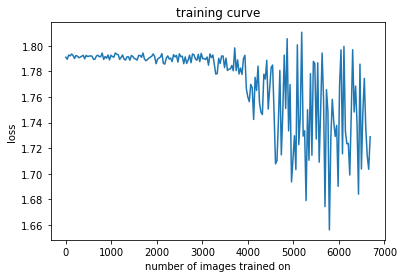

In [94]:
plt.plot(np.arange(len(losses)) * batch_size * 1, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

In [95]:
def test_accuracy(model, loss_function, test_data):

    '''
    This function will test the given model on the given test_data
    it will return the accuracy and the test loss (given by loss_function) 
    '''
    
    sum_loss = 0
    n_correct = 0
    total = 0

    for i, (spec, label) in enumerate(tqdm(iter(test_data))):

        # This is essentially exactly the same as the training loop 
        # without the, well, training, part (and we record the accuracy too)
        pred = model(spec)
        loss = loss_function(pred, label)
        sum_loss += loss.item()

        _, predicted = torch.max(pred,1)
        _, label = torch.max(label,1)
        n_correct += (predicted == label).sum()
        total += label.size(0)
    
    test_acc = round(((n_correct / total).item() * 100), 2)
    avg_loss = round(sum_loss / len(test_data), 2)

    print("test accuracy:", test_acc)
    print("test loss:", avg_loss )
    #test

    return test_acc, avg_loss

In [96]:
# To see how well your model is doing without hyperpameter tuning

print("testing the previously trained model")
test_acc,avg_loss = test_accuracy(model, loss_function, test_dataloader)

print("Testing accuracy of your first model:", test_acc)
print("Average loss of your first model:", avg_loss)

testing the previously trained model


























































































































100%|██████████| 24/24 [00:22<00:00,  1.06it/s]

test accuracy: 33.83
test loss: 1.71
Testing accuracy of your first model: 33.83
Average loss of your first model: 1.71
